## Qwen2.5VL-7B

* From Alibaba
* Ranked #7 in OpenCompass multimodal academic leaderboard for open-source models (https://rank.opencompass.org.cn/leaderboard-multimodal)



In [1]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from transformers import Qwen2_5_VLForConditionalGeneration
from transformers.models.qwen2_5_vl.modeling_qwen2_5_vl import Qwen2_5_VLCausalLMOutputWithPast
from qwen_vl_utils import process_vision_info
import torch
import os
from typing import Optional, List, Tuple, Union

class CustomQwen2_5_VLForConditionalGeneration(Qwen2_5_VLForConditionalGeneration):
    def __init__(self, config, threshold=-0.5):
        super().__init__(config)
        self.threshold = threshold

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        pixel_values: Optional[torch.Tensor] = None,
        pixel_values_videos: Optional[torch.FloatTensor] = None,
        image_grid_thw: Optional[torch.LongTensor] = None,
        video_grid_thw: Optional[torch.LongTensor] = None,
        rope_deltas: Optional[torch.LongTensor] = None,
        cache_position: Optional[torch.LongTensor] = None,
        second_per_grid_ts: Optional[torch.Tensor] = None,
    ) -> Union[Tuple, Qwen2_5_VLCausalLMOutputWithPast]:
        # Call the parent class's forward method to get the outputs
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            labels=labels,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=True,  # Ensure hidden states are returned for modification
            return_dict=return_dict,
            pixel_values=pixel_values,
            pixel_values_videos=pixel_values_videos,
            image_grid_thw=image_grid_thw,
            video_grid_thw=video_grid_thw,
            rope_deltas=rope_deltas,
            cache_position=cache_position,
            second_per_grid_ts=second_per_grid_ts,
        )

        # Modify the hidden_states before logits are computed
        hidden_states = outputs.hidden_states[-1]  # Get the last hidden state
        #hidden_states = outputs.hidden_states[-1][-1]  # Get the last hidden state
        modified_hidden_states = self.modify_hidden_states(hidden_states)

        # Recompute logits using the modified hidden states
        logits = self.lm_head(modified_hidden_states)

        # Return the modified outputs
        if not return_dict:
            return (logits,) + outputs[1:]

        return Qwen2_5_VLCausalLMOutputWithPast(
            loss=outputs.loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions if outputs.attentions is not None else [],  # Safeguard for attentions
            rope_deltas=outputs.rope_deltas,
        )
    
    def modify_hidden_states(self, hidden_states):
        if self.threshold is not None:
            threshold = self.threshold
            hidden_states = torch.relu(hidden_states - threshold) + threshold
        return hidden_states


def get_model_processor(model_dir, device='cuda:0'):

    target_class = CustomQwen2_5_VLForConditionalGeneration


    model = target_class.from_pretrained(
        model_dir, 
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
    ).to(device)

    # default processer
    processor = AutoProcessor.from_pretrained(
        model_dir, 
        # # if not enough memory:
        # min_pixels=min_pixels, 
        # max_pixels=max_pixels,
    )

    return model, processor 



def get_response(image, question: str, model, processor, device='cuda:0'):
    messages = [
        #{
        #    'role': 'system',
        #    'content': (
        #        "You FIRST think about the reasoning process as an internal monologue and then provide the final answer.\nThe reasoning process MUST BE enclosed within <think> </think> tags. The final answer MUST BE enclosed within <answer> </answer> tags."
        #        #"As an AI assistant, you specialize in accurate image object detection, delivering coordinates in plain text format '[x1,y1,x2,y2] object'."
        #    )
        #},
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": question},
            ],
        }
    ]
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(device)

    # Inference: Generation of the output
    #generated_ids = model.generate(**inputs, max_new_tokens=1000, do_sample=False, use_cache=True)
    generated_ids = model.generate(**inputs, max_new_tokens=2000, do_sample=False, use_cache=True)
    torch.cuda.empty_cache()
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    # print(output_text)


    return output_text[0]



/data/students/earl/anaconda3/envs/evalqwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Loading checkpoint shards: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/data/students/earl/anaconda3/envs/evalqwen/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


```json
[
	{"bbox_2d": [240, 500, 336, 570], "label": "catcher's shin guards"}
]
```
Bounding Boxes: [[240.0, 500.0, 336.0, 570.0]]


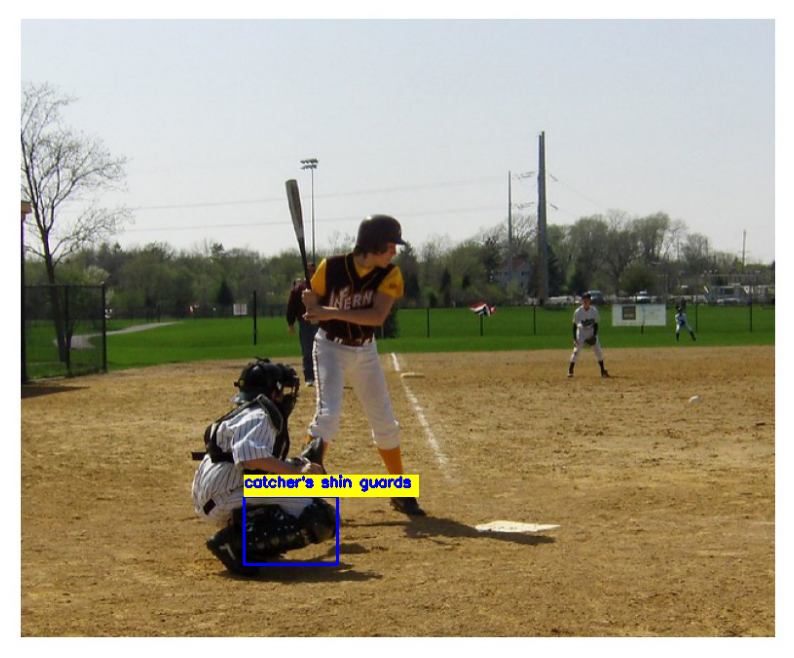

In [2]:
import io
import matplotlib.pyplot as plt
import re
import cv2
import numpy as np
from PIL import Image
import requests


model_dir = '/data/students/earl/llava-dissector/Qwen2.5-VL-7B-Instruct'
device = 'cuda:7'
model, processor = get_model_processor(model_dir, device)


cls = "catcher's shin guards"
model.threshold =  -1.5   

#text = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image'
text = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image.' # the ending period seems to matter
#text = f'Give the normalized bounding box coordinates of all instances of {cls} in the image.'
#text = f'Describe the image.'

#image = url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg" #os.path.join('./assets/example.jpg')
image = url = "/data/students/earl/llava-dissector/rca/assets/game_at_the_park.jpg" #os.path.join('./assets/example.jpg')


#image = url = "/data/vlm/playground/data/coco/val2017/000000009400.jpg"     # cup  # model.threshold =
#image = url = "/data/vlm/playground/data/coco/val2017/000000015517.jpg"     # bus # model.threshold = 0 (=10 buses), 0.03 (=11 buses)
#image = url = "/data/vlm/playground/data/coco/val2017/000000571804.jpg"     # sink  # model.threshold = -2.5
#image = url = "/data/vlm/playground/data/coco/val2017/000000352684.jpg"     # tie  # model.threshold = 
#image = url = "/data/vlm/playground/data/coco/val2017/000000117645.jpg"     # snowboard  # model.threshold = 0
#image = url = "/data/vlm/playground/data/coco/val2017/000000331352.jpg"     # sink  # model.threshold = 0


response = get_response(
    image,
    #f'<detect> {text}',
    text,
    model, 
    processor,
    device=device,
)

print(response)

# regex the part of string to extract bounding boxes
#pattern = r'\[\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*\]'
#pattern = r'[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*[\]\)]'
pattern = r'(?:[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)(?:\s*[\]\)]|</box>))|(?:<box>\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*</box>)'
matches = re.findall(pattern, response)
bounding_boxes = []
for match in matches:
    nums = [x for x in match if x != '']
    if len(nums) == 4:
        bounding_boxes.append([float(x) for x in nums])

#bounding_boxes = [[int(coord) for coord in match] for match in matches]
print(f'Bounding Boxes: {bounding_boxes}')

# Visualize using cv2
# Load the original image for visualization
#image_from_url = requests.get(url)
if isinstance(image, str) and (image.startswith('http://') or image.startswith('https://')):
    response = requests.get(image)
    orig_img = Image.open(io.BytesIO(response.content)).convert('RGB')
    #orig_img = Image.open(io.BytesIO(image_from_url.content)).convert('RGB')
else:
    orig_img = Image.open(image).convert('RGB')

img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    h, w, _ = img_cv.shape
    # Check if all coordinates are normalized (<= 1.0)
    if all(coord <= 1.0 for coord in box):
        x1, y1, x2, y2 = [int(coord * dim) for coord, dim in zip(box, [w, h, w, h])]
    else:
        x1, y1, x2, y2 = [int(coord) for coord in box]
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 0, 255), 2) # blue rectangle
    (text_width, text_height), _ = cv2.getTextSize(cls, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
    box_coords = ((x1, y1), (x1 + text_width + 5, y1 - 10 - text_height))
    cv2.rectangle(img_cv, box_coords[0], box_coords[1], (255,255,0), cv2.FILLED)  # yellow rectangle
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2) # blue
    
plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 


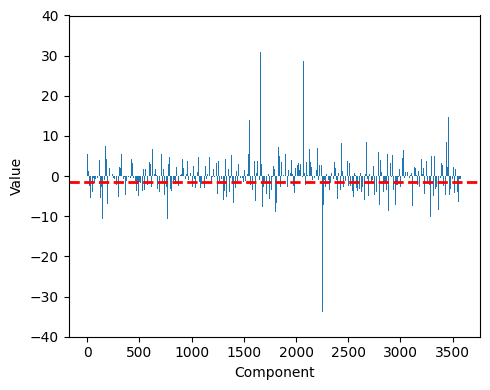

In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np

question = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image.' # the ending period seems to matter


messages = [
    #{
    #    'role': 'system',
    #    'content': (
    #        "You FIRST think about the reasoning process as an internal monologue and then provide the final answer.\nThe reasoning process MUST BE enclosed within <think> </think> tags. The final answer MUST BE enclosed within <answer> </answer> tags."
    #        #"As an AI assistant, you specialize in accurate image object detection, delivering coordinates in plain text format '[x1,y1,x2,y2] object'."
    #    )
    #},
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question},
        ],
    }
]
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(device)

    # Inference: Generation of the output
    #generated_ids = model.generate(**inputs, max_new_tokens=1000, do_sample=False, use_cache=True)
    

# Prepare the input as in your get_response function
with torch.inference_mode():
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=False,
        use_cache=True,
        output_hidden_states=True,
        output_attentions=True,
        return_dict_in_generate=True,
        output_scores=True
    )

# Choose the token index to visualize (e.g., the first generated token)
# You can change this index as desired
chosen_token_idx = -1  # -1 for the last generated token, or set to another index

# Extract the hidden state vector for the chosen token
# outputs.hidden_states: tuple of (layers, batch, seq_len, hidden_dim)
# outputs.sequences: (batch, seq_len)
last_hidden_states = outputs.hidden_states[-1][-1]  # (batch, seq_len, hidden_dim)
hidden_vec = last_hidden_states[0, chosen_token_idx, :].to(torch.float32).cpu().numpy()
'''
# Extract the attention weights for the chosen token
# outputs.attentions: tuple of (layers, batch, num_heads, seq_len, seq_len)
# We'll use the last layer, first batch, all heads, and the chosen token as the query
last_attn = outputs.attentions[-1][-1]  # (batch, num_heads, seq_len, seq_len)
attn_for_token = last_attn[0, :, chosen_token_idx, :]  # (num_heads, seq_len)
# Optionally, average over heads
attn_for_token_mean = attn_for_token.mean(axis=0).to(torch.float32).cpu().numpy()
'''

# Floor the hidden state vector at -1.5
hidden_vec_floored = np.maximum(hidden_vec, -1.5)

#plt.figure(figsize=(10, 4))
plt.figure(figsize=(5, 4))

# Subplot 1: Original hidden state vector
#plt.subplot(1, 2, 1)
plt.bar(np.arange(len(hidden_vec)), hidden_vec)
#plt.title(f'Hidden State Vector for Token {chosen_token_idx}')
plt.xlabel('Component')
plt.ylabel('Value')
plt.ylim(-40,40)
# Add red horizontal dashed line at y=-1.5
plt.axhline(y=-1.5, color='red', linestyle='--', linewidth=2)
'''

# Subplot 2: Floored hidden state vector
#plt.subplot(1, 2, 2)
plt.bar(np.arange(len(hidden_vec_floored)), hidden_vec_floored)
#plt.title(f'Hidden State Vector (Floored at -1.5) for Token {chosen_token_idx}')
plt.xlabel('Component')
#plt.ylabel('Value (floored)')
plt.ylim(-40,40)
'''
# Add LaTeX symbol between subplots
#plt.figtext(0.5, 0.5, r'$\Rightarrow{\Huge\boxed{\widetilde{A}}}\Rightarrow$', ha='center', va='center', fontsize=28)
#plt.figtext(0.5, 0.5, r'$\Rightarrow$ [~A] $\Rightarrow$', ha='center', va='center', fontsize=28)

plt.tight_layout()
plt.show()